In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import talib  # Thư viện cho các chỉ báo kỹ thuật
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

# 1. Tải dữ liệu
start = '2010-01-01'
end = datetime.today().strftime('%Y-%m-%d')
stock = 'GOOG'
data = yf.download(stock, start, end)

# Xóa MultiIndex, giữ lại tên cột gốc (nếu có)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.droplevel(1)

# 2. Tính toán các chỉ báo kỹ thuật
data['SMA_50'] = talib.SMA(data['Close'].values, timeperiod=50)
data['EMA_20'] = talib.EMA(data['Close'].values, timeperiod=20)
data['RSI_14'] = talib.RSI(data['Close'].values, timeperiod=14)
data['MACD'], data['MACD_signal'], _ = talib.MACD(data['Close'].values, fastperiod=12, slowperiod=26, signalperiod=9)
data['Upper_BB'], data['Middle_BB'], data['Lower_BB'] = talib.BBANDS(data['Close'].values, timeperiod=20, nbdevup=2, nbdevdn=2)
data['ADX_14'] = talib.ADX(data['High'].values, data['Low'].values, data['Close'].values, timeperiod=14)

# Xóa dữ liệu NaN do tính toán chỉ báo
data.dropna(inplace=True)
data.reset_index(inplace=True)

2025-03-20 09:31:48.401002: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-20 09:31:48.407246: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-20 09:31:48.459756: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-20 09:31:48.504375: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742437908.547885   12054 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742437908.56

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
features = ['Close', 'SMA_50', 'EMA_20', 'RSI_14', 'MACD', 'MACD_signal', 'Upper_BB', 'Lower_BB', 'ADX_14']
train_size = int(len(data) * 0.80)

data_train = data[features].iloc[:train_size]
data_test = data[features].iloc[train_size:]

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
data_train_scaled = scaler.fit_transform(data_train)
data_test_scaled = scaler.transform(data_test)

# 4. Chuẩn bị dữ liệu cho LSTM (train)
x_train, y_train = [], []
sequence_length = 100  # Sử dụng 100 ngày trước để dự đoán

for i in range(sequence_length, len(data_train_scaled)):
    x_train.append(data_train_scaled[i-sequence_length:i])
    y_train.append(data_train_scaled[i, 0])  # Dự đoán giá Close ngày tiếp theo

x_train, y_train = np.array(x_train), np.array(y_train)

In [5]:
model = Sequential([
    LSTM(units=80, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], len(features))),
    Dropout(0.2),
    LSTM(units=100, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(units=120, activation='relu'),
    Dropout(0.2),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

2025-03-20 09:31:57.296210: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/phung/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(x_train, y_train, epochs=100, batch_size=32, callbacks=[early_stopping])


Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - loss: 0.0273
Epoch 2/100
 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - loss: 0.0034

/home/phung/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - loss: 0.0018
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - loss: 0.0018
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - loss: 0.0016
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - loss: 0.0014
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - loss: 0.0014
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - loss: 0.0012
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 179ms/step - loss: 0.0015
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - loss: 9.6811e-04
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - loss: 0.0011
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - loss: 0.0011
Epoch 12/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - loss: 9.1832e-04
Epoch 13/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - loss: 9.9132e-04
Epoch 14/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step - loss: 8.2959e-04
Epoch 15/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - loss: 0.0010
Epoch 16/100
92/92 ━━━━━

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


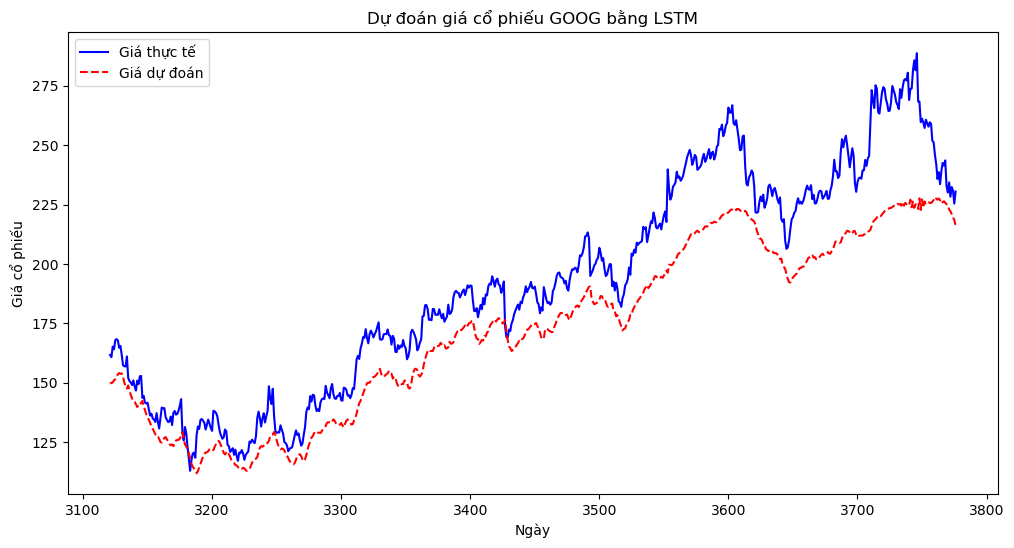

In [11]:
x_test, y_test = [], []

for i in range(sequence_length, len(data_test_scaled)):
    x_test.append(data_test_scaled[i-sequence_length:i])
    y_test.append(data_test_scaled[i, 0])  # Giá thực tế cần dự đoán

x_test, y_test = np.array(x_test), np.array(y_test)

# 8. Dự đoán giá trên tập test
predicted_prices = model.predict(x_test)

# Chuyển đổi giá trị về thang đo ban đầu
scaler_close = MinMaxScaler()
scaler_close.fit(data[['Close']])  # Chỉ fit trên giá Close để đảo ngược dự đoán
predicted_prices = scaler_close.inverse_transform(predicted_prices.reshape(-1, 1))
actual_prices = scaler_close.inverse_transform(y_test.reshape(-1, 1))

# 9. Vẽ biểu đồ kết quả
plt.figure(figsize=(12, 6))
plt.plot(data.index[train_size + sequence_length:], actual_prices, color='blue', label='Giá thực tế')
plt.plot(data.index[train_size + sequence_length:], predicted_prices, color='red', linestyle='dashed', label='Giá dự đoán')
plt.title(f'Dự đoán giá cổ phiếu {stock} bằng LSTM')
plt.xlabel('Ngày')
plt.ylabel('Giá cổ phiếu')
plt.legend()
plt.show()

In [13]:
model.save('lstm_stock_model.keras')
